In [10]:
import jax
import jax.numpy as jnp
import numpy as np
import json
from typing import Tuple, Dict, Any
from flax.training import train_state
import tensorflow as tf

class PhotoSketchDataset:
    def __init__(self, data_path: str, num_points: int = 100, image_size: int = 28):
        self.data_path = data_path
        self.num_points = num_points
        self.image_size = image_size
        self.drawings = []
        
        # Load the NDJSON file
        with open(data_path, 'r') as f:
            for line in f:
                drawing_data = json.loads(line)
                if drawing_data["recognized"]:  # Only use recognized drawings
                    self.drawings.append(drawing_data)
        
        # Load bitmap data
        bitmap_path = self.data_path.replace('-simplified-bird.ndjson', '-numpy_bitmap-bird.npy')
        self.bitmaps = np.load(bitmap_path)
        
        # Convert to numpy arrays for better performance
        self._preprocess_data()
    
    def _preprocess_data(self):
        """Preprocess all data at once for better performance"""
        processed_points = []
        processed_bitmaps = []
        
        for idx in range(len(self.drawings)):
            points, bitmap = self._process_single_item(idx)
            processed_points.append(points)
            processed_bitmaps.append(bitmap)
        
        self.processed_points = np.stack(processed_points)
        self.processed_bitmaps = np.stack(processed_bitmaps)
    
    def _process_single_item(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        """Process a single drawing item"""
        drawing_data = self.drawings[idx]
        strokes = drawing_data["drawing"]
        
        # Convert strokes to absolute coordinates
        all_points = []
        for stroke in strokes:
            x_coords = np.array(stroke[0])
            y_coords = np.array(stroke[1])
            points = np.stack([x_coords, y_coords], axis=1)
            all_points.append(points)
        
        # Concatenate all strokes
        all_points = np.concatenate(all_points, axis=0)
        
        # Normalize coordinates to [0, 1]
        all_points = all_points.astype(np.float32)
        all_points[:, 0] = all_points[:, 0] / 255.0  # X coordinates
        all_points[:, 1] = all_points[:, 1] / 255.0  # Y coordinates
        
        # Sample or pad to desired number of points
        if len(all_points) > self.num_points:
            indices = np.random.choice(len(all_points), self.num_points, replace=False)
            all_points = all_points[indices]
        else:
            padding = np.pad(
                all_points,
                ((0, self.num_points - len(all_points)), (0, 0)),
                mode='wrap'
            )
            all_points = padding
        
        # Get and process bitmap
        bitmap = self.bitmaps[idx]
        bitmap = bitmap.reshape(self.image_size, self.image_size)
        bitmap = bitmap.astype(np.float32) / 255.0
        
        return all_points, bitmap

    def get_dataset(self, batch_size: int = 32, shuffle: bool = True) -> tf.data.Dataset:
        """Create a tf.data.Dataset for efficient batching and prefetching"""
        # Convert numpy arrays to tensors
        points_tensor = tf.convert_to_tensor(self.processed_points, dtype=tf.float32)
        bitmaps_tensor = tf.convert_to_tensor(self.processed_bitmaps, dtype=tf.float32)
        
        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((bitmaps_tensor, points_tensor))
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(self.drawings))
        
        # Batch and prefetch
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        return dataset

def get_dataloaders(data_path: str, batch_size: int = 32, num_points: int = 100) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    """Create train and test datasets"""
    dataset = PhotoSketchDataset(data_path, num_points=num_points)
    
    # Calculate split sizes
    total_size = len(dataset.drawings)
    train_size = int(0.8 * total_size)
    
    # Create train/test splits
    indices = np.random.permutation(total_size)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    # Split the preprocessed data
    train_points = dataset.processed_points[train_indices]
    train_bitmaps = dataset.processed_bitmaps[train_indices]
    test_points = dataset.processed_points[test_indices]
    test_bitmaps = dataset.processed_bitmaps[test_indices]
    
    # Create datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_bitmaps, train_points))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_bitmaps, test_points))
    
    # Configure datasets
    train_dataset = train_dataset.shuffle(buffer_size=len(train_indices))
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, test_dataset

# Utility functions for visualization
def show_samples(dataset: tf.data.Dataset, num_samples: int = 5):
    """
    Show samples from the dataset
    Args:
        dataset: tf.data.Dataset instance
        num_samples: Number of samples to show
    """
    import matplotlib.pyplot as plt
    
    # Get samples
    samples = next(iter(dataset.take(1)))
    bitmaps, coords = samples
    
    # Convert to numpy for matplotlib
    bitmaps = bitmaps.numpy()
    coords = coords.numpy()
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i in range(min(num_samples, bitmaps.shape[0])):
        # Plot bitmap
        axes[0, i].imshow(bitmaps[i], cmap='gray')
        axes[0, i].set_title(f'Bitmap {i+1}')
        axes[0, i].axis('off')
        
        # Plot vector coordinates
        axes[1, i].scatter(coords[i, :, 0], coords[i, :, 1], s=1, c='black', alpha=0.5)
        axes[1, i].set_xlim(0, 1)
        axes[1, i].set_ylim(0, 1)
        axes[1, i].invert_yaxis()  # Invert Y axis to match image coordinates
        axes[1, i].set_aspect('equal')
        axes[1, i].set_title(f'Vector {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test the dataset implementation
def test_dataset():
    # Create a small test dataset
    dataset = PhotoSketchDataset('../data/full-simplified-bird.ndjson', num_points=100)
    train_ds, test_ds = get_dataloaders(
        '../data/full-simplified-bird.ndjson',
        batch_size=32,
        num_points=100
    )
    
    # Print dataset info
    print(f"Dataset size: {len(dataset.drawings)}")
    
    # Test batch iteration
    for bitmaps, coords in train_ds.take(1):
        print(f"Batch shapes - Bitmaps: {bitmaps.shape}, Coords: {coords.shape}")
        break

if __name__ == "__main__":
    test_dataset()

Dataset size: 111611
Batch shapes - Bitmaps: (32, 28, 28), Coords: (32, 100, 2)


Original coords shape: (4, 100, 2)
Noised coords shape: (4, 100, 2)
Timesteps shape: (4,)


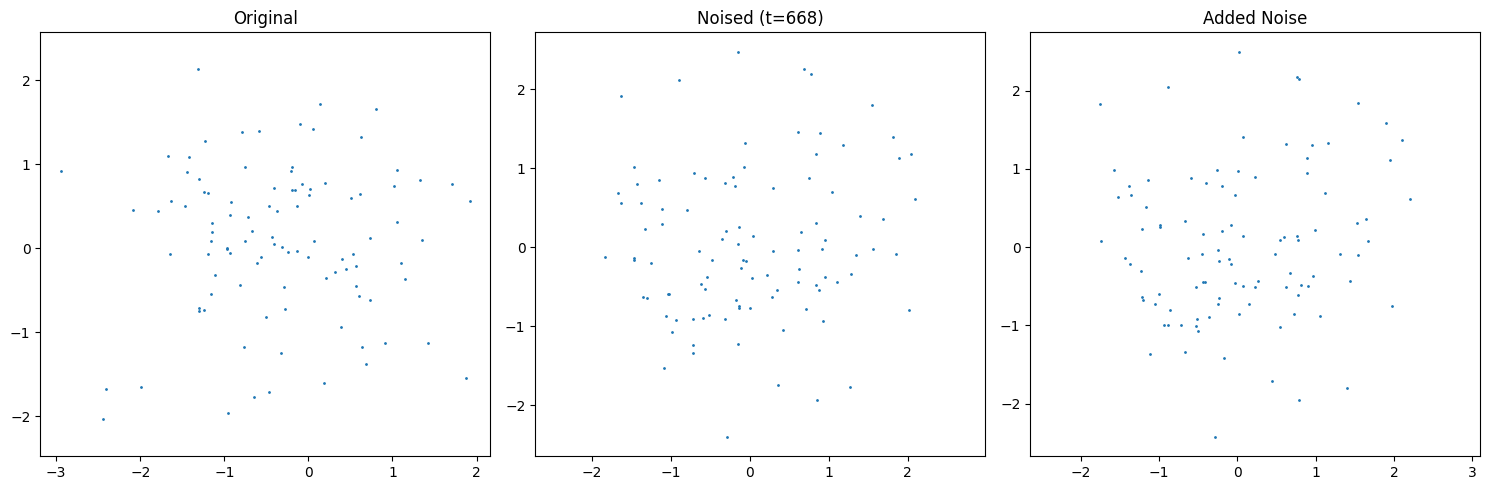

In [11]:
# diffusion.py

import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Optional
from functools import partial

class DiffusionProcess:
    def __init__(
        self,
        num_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        dtype: jnp.dtype = jnp.float32
    ):
        self.num_timesteps = num_timesteps
        self.dtype = dtype
        
        # Define noise schedule
        self.betas = jnp.linspace(beta_start, beta_end, num_timesteps, dtype=dtype)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = jnp.cumprod(self.alphas)
        
        # Pre-compute values for sampling
        self.sqrt_alphas_cumprod = jnp.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = jnp.sqrt(1.0 - self.alphas_cumprod)
        
        # Pre-compute values for inference
        self.sqrt_recip_alphas = jnp.sqrt(1.0 / self.alphas)
        alphas_cumprod_prev = jnp.append(jnp.array([1.0]), self.alphas_cumprod[:-1])
        self.posterior_variance = self.betas * (1.0 - alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def _sample_timesteps_impl(self, key: jnp.ndarray, batch_size: int) -> jnp.ndarray:
        """Implementation of timestep sampling, separated for proper JIT compilation"""
        return random.randint(
            key,
            shape=(batch_size,),
            minval=0,
            maxval=self.num_timesteps,
            dtype=jnp.int32
        )

    def sample_timesteps(self, key: jnp.ndarray, batch_size: int) -> jnp.ndarray:
        """
        Sample random timesteps for a batch.
        
        Args:
            key: JAX PRNG key
            batch_size: Size of batch to generate timesteps for
            
        Returns:
            timesteps: Random timesteps array
        """
        # Create a JIT-compiled version of the implementation with batch_size as static
        sample_fn = jax.jit(
            self._sample_timesteps_impl,
            static_argnums=(1,)
        )
        return sample_fn(key, batch_size)

    @partial(jax.jit, static_argnums=(0,))
    def add_noise(
        self,
        key: jnp.ndarray,
        sketch_coords: jnp.ndarray,
        timesteps: jnp.ndarray
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Add noise to sketch coordinates based on timestep.
        """
        noise = random.normal(
            key,
            sketch_coords.shape,
            dtype=self.dtype
        )
        
        sqrt_alphas = jnp.take(self.sqrt_alphas_cumprod, timesteps)
        sqrt_one_minus_alphas = jnp.take(self.sqrt_one_minus_alphas_cumprod, timesteps)
        
        sqrt_alphas = sqrt_alphas[:, None, None]
        sqrt_one_minus_alphas = sqrt_one_minus_alphas[:, None, None]
        
        noised_coords = sqrt_alphas * sketch_coords + sqrt_one_minus_alphas * noise
        return noised_coords, noise

    @partial(jax.jit, static_argnums=(0,))
    def remove_noise(
        self,
        noised_coords: jnp.ndarray,
        pred_noise: jnp.ndarray,
        timesteps: jnp.ndarray
    ) -> jnp.ndarray:
        """
        Remove predicted noise from noised coordinates.
        """
        sqrt_alphas = jnp.take(self.sqrt_alphas_cumprod, timesteps)
        sqrt_one_minus_alphas = jnp.take(self.sqrt_one_minus_alphas_cumprod, timesteps)
        
        sqrt_alphas = sqrt_alphas[:, None, None]
        sqrt_one_minus_alphas = sqrt_one_minus_alphas[:, None, None]
        
        return (noised_coords - sqrt_one_minus_alphas * pred_noise) / sqrt_alphas

    @partial(jax.jit, static_argnums=(0,))
    def q_sample(
        self,
        key: jnp.ndarray,
        sketch_coords: jnp.ndarray,
        timesteps: jnp.ndarray
    ) -> jnp.ndarray:
        """Sample from the forward diffusion process."""
        noised_coords, _ = self.add_noise(key, sketch_coords, timesteps)
        return noised_coords

    @partial(jax.jit, static_argnums=(0,))
    def p_sample(
        self,
        key: jnp.ndarray,
        model_fn,
        noised_coords: jnp.ndarray,
        timesteps: jnp.ndarray,
        clip_denoised: bool = True
    ) -> jnp.ndarray:
        """Sample from the reverse diffusion process (single step)."""
        pred_noise = model_fn(noised_coords, timesteps)
        pred_coords = self.remove_noise(noised_coords, pred_noise, timesteps)
        
        if clip_denoised:
            pred_coords = jnp.clip(pred_coords, -1.0, 1.0)
        return pred_coords

def test_diffusion():
    """Test the diffusion process implementation"""
    import matplotlib.pyplot as plt
    
    # Initialize
    key = random.PRNGKey(0)
    diffusion = DiffusionProcess()
    
    # Create dummy data
    batch_size = 4
    num_points = 100
    key, subkey = random.split(key)
    sketch_coords = random.normal(
        subkey,
        shape=(batch_size, num_points, 2)
    )
    
    # Sample timesteps
    key, subkey = random.split(key)
    timesteps = diffusion.sample_timesteps(subkey, batch_size)
    
    # Add noise
    key, subkey = random.split(key)
    noised_coords, noise = diffusion.add_noise(subkey, sketch_coords, timesteps)
    
    # Test shapes
    print(f"Original coords shape: {sketch_coords.shape}")
    print(f"Noised coords shape: {noised_coords.shape}")
    print(f"Timesteps shape: {timesteps.shape}")
    
    # Visualize noising process for first example
    plt.figure(figsize=(15, 5))
    
    # Original
    plt.subplot(131)
    plt.scatter(sketch_coords[0, :, 0], sketch_coords[0, :, 1], s=1)
    plt.title("Original")
    plt.axis('equal')
    
    # Noised
    plt.subplot(132)
    plt.scatter(noised_coords[0, :, 0], noised_coords[0, :, 1], s=1)
    plt.title(f"Noised (t={timesteps[0]})")
    plt.axis('equal')
    
    # Noise
    plt.subplot(133)
    plt.scatter(noise[0, :, 0], noise[0, :, 1], s=1)
    plt.title("Added Noise")
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    test_diffusion()

In [12]:
# decoder.py
import jax
import jax.numpy as jnp
import flax.linen as nn
from typing import Optional, Tuple
import math
from functools import partial

class PositionalEncoding(nn.Module):
    """Positional encoding module using sinusoidal functions"""
    d_model: int
    max_len: int = 5000
    
    def setup(self):
        position = jnp.arange(self.max_len)[:, None]
        div_term = jnp.exp(
            jnp.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model)
        )
        
        pe = jnp.zeros((self.max_len, self.d_model))
        pe = pe.at[:, 0::2].set(jnp.sin(position * div_term))
        pe = pe.at[:, 1::2].set(jnp.cos(position * div_term))
        
        self.pe = pe
    
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        x = x + self.pe[:x.shape[1]]
        return x

class TimestepEmbedding(nn.Module):
    """Timestep embedding module"""
    embed_dim: int
    
    @nn.compact
    def __call__(self, timesteps: jnp.ndarray) -> jnp.ndarray:
        timesteps = timesteps[:, None].astype(jnp.float32)
        x = nn.Dense(self.embed_dim)(timesteps)
        x = nn.silu(x)
        x = nn.Dense(self.embed_dim)(x)
        return x

class MultiHeadAttention(nn.Module):
    """Multi-head attention module with proper masking support"""
    num_heads: int
    d_model: int
    dropout_rate: float = 0.1
    deterministic: bool = True
    
    def setup(self):
        head_dim = self.d_model // self.num_heads
        self.scale = head_dim ** -0.5
        
        self.qkv = nn.Dense(3 * self.d_model, use_bias=False)
        self.proj = nn.Dense(self.d_model)
        self.dropout = nn.Dropout(rate=self.dropout_rate)
    
    def __call__(
        self,
        x: jnp.ndarray,
        mask: Optional[jnp.ndarray] = None,
        deterministic: Optional[bool] = None
    ) -> jnp.ndarray:
        deterministic = self.deterministic if deterministic is None else deterministic
        batch_size, seq_len = x.shape[:2]
        
        # Get query, key, value projections
        qkv = self.qkv(x)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, -1)
        qkv = qkv.transpose(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Compute attention
        attn = (q @ k.transpose(0, 1, 3, 2)) * self.scale
        
        if mask is not None:
            attn = jnp.where(mask == 0, float('-inf'), attn)
        
        attn = jax.nn.softmax(attn, axis=-1)
        attn = self.dropout(attn, deterministic=deterministic)
        
        x = (attn @ v).transpose(0, 2, 1, 3).reshape(batch_size, seq_len, self.d_model)
        x = self.proj(x)
        x = self.dropout(x, deterministic=deterministic)
        
        return x

class TransformerDecoderLayer(nn.Module):
    """Single transformer decoder layer"""
    d_model: int
    nhead: int
    dim_feedforward: int = 2048
    dropout: float = 0.1
    deterministic: bool = True
    
    @nn.compact
    def __call__(
        self,
        tgt: jnp.ndarray,
        memory: jnp.ndarray,
        tgt_mask: Optional[jnp.ndarray] = None,
        memory_mask: Optional[jnp.ndarray] = None,
        deterministic: Optional[bool] = None
    ) -> jnp.ndarray:
        deterministic = self.deterministic if deterministic is None else deterministic
        
        # Self attention
        x = nn.LayerNorm()(tgt)
        x = MultiHeadAttention(
            num_heads=self.nhead,
            d_model=self.d_model,
            dropout_rate=self.dropout,
            deterministic=deterministic
        )(x, mask=tgt_mask)
        tgt = tgt + x
        
        # Cross attention
        x = nn.LayerNorm()(tgt)
        x = MultiHeadAttention(
            num_heads=self.nhead,
            d_model=self.d_model,
            dropout_rate=self.dropout,
            deterministic=deterministic
        )(x, mask=memory_mask)
        tgt = tgt + x
        
        # Feedforward
        x = nn.LayerNorm()(tgt)
        x = nn.Dense(self.dim_feedforward)(x)
        x = nn.gelu(x)
        x = nn.Dropout(rate=self.dropout)(x, deterministic=deterministic)
        x = nn.Dense(self.d_model)(x)
        x = nn.Dropout(rate=self.dropout)(x, deterministic=deterministic)
        tgt = tgt + x
        
        return tgt

class TransformerDecoder(nn.Module):
    """Complete transformer decoder"""
    d_model: int = 512
    nhead: int = 8
    num_layers: int = 6
    dim_feedforward: int = 2048
    dropout: float = 0.1
    max_seq_length: int = 1000
    deterministic: bool = True
    
    def setup(self):
        # Create embedding modules
        self.coord_embed = nn.Dense(self.d_model)
        self.timestep_embed = TimestepEmbedding(self.d_model)
        self.pos_encoder = PositionalEncoding(self.d_model, self.max_seq_length)
        
        # Create decoder layers
        self.layers = [
            TransformerDecoderLayer(
                d_model=self.d_model,
                nhead=self.nhead,
                dim_feedforward=self.dim_feedforward,
                dropout=self.dropout,
                deterministic=self.deterministic
            )
            for _ in range(self.num_layers)
        ]
        
        # Output projection
        self.output_proj = nn.Dense(2)
    
    def __call__(
        self,
        noised_coords: jnp.ndarray,
        timesteps: jnp.ndarray,
        image_embedding: jnp.ndarray,
        key_padding_mask: Optional[jnp.ndarray] = None,
        deterministic: Optional[bool] = None
    ) -> jnp.ndarray:
        deterministic = self.deterministic if deterministic is None else deterministic
        
        # Embed coordinates
        x = self.coord_embed(noised_coords)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Get timestep embeddings and expand to sequence length
        t_emb = self.timestep_embed(timesteps)
        t_emb = jnp.expand_dims(t_emb, axis=1)
        t_emb = jnp.tile(t_emb, (1, x.shape[1], 1))
        
        # Combine coordinate embeddings with timestep embeddings
        x = x + t_emb
        
        # Prepare image embedding as memory for cross-attention
        memory = jnp.expand_dims(image_embedding, axis=1)
        
        # Apply transformer decoder layers
        for layer in self.layers:
            x = layer(
                x,
                memory,
                tgt_mask=None,
                memory_mask=None,
                deterministic=deterministic
            )
        
        # Project back to coordinates
        pred_coords = self.output_proj(x)
        
        return pred_coords

def create_decoder_params(
    key: jnp.ndarray,
    batch_size: int = 1,
    seq_length: int = 100,
    d_model: int = 512
) -> dict:
    """Initialize decoder parameters"""
    decoder = TransformerDecoder(d_model=d_model)
    
    # Create dummy inputs for initialization
    dummy_coords = jnp.ones((batch_size, seq_length, 2))
    dummy_timesteps = jnp.zeros((batch_size,), dtype=jnp.int32)
    dummy_image_embedding = jnp.ones((batch_size, d_model))
    
    # Initialize parameters
    return decoder.init(
        key,
        dummy_coords,
        dummy_timesteps,
        dummy_image_embedding,
        deterministic=True
    )

def test_decoder():
    """Test the transformer decoder implementation"""
    import jax.random as random
    
    # Create random key
    key = random.PRNGKey(0)
    
    # Create dummy inputs
    batch_size = 4
    seq_length = 100
    d_model = 256
    
    noised_coords = jnp.ones((batch_size, seq_length, 2))
    timesteps = jnp.zeros((batch_size,), dtype=jnp.int32)
    image_embedding = jnp.ones((batch_size, d_model))
    
    # Initialize model
    decoder = TransformerDecoder(d_model=d_model)
    params = create_decoder_params(key, batch_size, seq_length, d_model)
    
    # Forward pass
    output = decoder.apply(
        params,
        noised_coords,
        timesteps,
        image_embedding,
        deterministic=True
    )
    
    print(f"Input coords shape: {noised_coords.shape}")
    print(f"Output coords shape: {output.shape}")
    print("Test successful!")

if __name__ == "__main__":
    test_decoder()

Input coords shape: (4, 100, 2)
Output coords shape: (4, 100, 2)
Test successful!


In [13]:
#encoder.py
import jax
import jax.numpy as jnp
import flax.linen as nn
from typing import Tuple, Optional, Dict, Any
from functools import partial

class ConvBNAct(nn.Module):
    """Convolution-BatchNorm-Activation block"""
    features: int
    kernel_size: Tuple[int, int] = (3, 3)
    strides: Tuple[int, int] = (1, 1)
    padding: str = 'SAME'
    use_bias: bool = False
    
    @nn.compact
    def __call__(self, x: jnp.ndarray, training: bool = True) -> jnp.ndarray:
        x = nn.Conv(
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            use_bias=self.use_bias
        )(x)
        x = nn.BatchNorm(
            use_running_average=not training,
            momentum=0.9,
            epsilon=1e-5
        )(x)
        return nn.relu(x)

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""
    features: int
    reduction_ratio: int = 4
    
    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        input_channels = x.shape[-1]
        
        # Global Average Pooling
        pooled = jnp.mean(x, axis=(1, 2), keepdims=True)
        
        # Reduction
        reduced = nn.Conv(
            features=max(1, input_channels // self.reduction_ratio),
            kernel_size=(1, 1)
        )(pooled)
        reduced = nn.relu(reduced)
        
        # Expansion
        expanded = nn.Conv(
            features=input_channels,
            kernel_size=(1, 1)
        )(reduced)
        weights = nn.sigmoid(expanded)
        
        return x * weights

class InvertedResidual(nn.Module):
    """MobileNetV3 Inverted Residual block"""
    features: int
    stride: int
    expand_ratio: int = 6
    use_se: bool = True
    
    @nn.compact
    def __call__(self, x: jnp.ndarray, training: bool = True) -> jnp.ndarray:
        input_channels = x.shape[-1]
        expanded_features = input_channels * self.expand_ratio
        
        # Expansion
        if self.expand_ratio != 1:
            residual = ConvBNAct(
                features=expanded_features,
                kernel_size=(1, 1)
            )(x, training=training)
        else:
            residual = x
        
        # Depthwise
        residual = nn.Conv(
            features=expanded_features,
            kernel_size=(3, 3),
            strides=(self.stride, self.stride),
            padding='SAME',
            feature_group_count=expanded_features
        )(residual)
        residual = nn.BatchNorm(use_running_average=not training)(residual)
        residual = nn.relu(residual)
        
        # SE block
        if self.use_se:
            residual = SEBlock(features=expanded_features)(residual)
        
        # Projection
        residual = ConvBNAct(
            features=self.features,
            kernel_size=(1, 1)
        )(residual, training=training)
        
        # Skip connection
        if self.stride == 1 and input_channels == self.features:
            return x + residual
        return residual

class BitmapEncoder(nn.Module):
    """Encodes bitmap images into fixed-dimensional embeddings"""
    embed_dim: int = 256
    
    @nn.compact
    def __call__(self, bitmap: jnp.ndarray, training: bool = True) -> jnp.ndarray:
        # Ensure input has correct shape
        if bitmap.ndim == 3:
            bitmap = jnp.expand_dims(bitmap, axis=-1)
        
        # Initial conv to get to 3 channels
        x = nn.Conv(features=3, kernel_size=(1, 1))(bitmap)
        
        # Early layers adapted for 28x28 input
        x = ConvBNAct(
            features=16,
            kernel_size=(3, 3),
            strides=(2, 2)
        )(x, training=training)
        
        x = InvertedResidual(
            features=24,
            stride=2,
            expand_ratio=4,
            use_se=True
        )(x, training=training)
        
        x = InvertedResidual(
            features=32,
            stride=1,
            expand_ratio=4,
            use_se=True
        )(x, training=training)
        
        # Feature processor
        x = ConvBNAct(
            features=64,
            kernel_size=(1, 1)
        )(x, training=training)
        
        x = ConvBNAct(
            features=self.embed_dim,
            kernel_size=(1, 1)
        )(x, training=training)
        
        # Global average pooling
        x = jnp.mean(x, axis=(1, 2))
        
        return x

def create_encoder_params(
    key: jnp.ndarray,
    batch_size: int = 1,
    image_size: Tuple[int, int] = (28, 28),
    embed_dim: int = 256
) -> Dict[str, Any]:
    """Initialize encoder parameters"""
    encoder = BitmapEncoder(embed_dim=embed_dim)
    dummy_bitmap = jnp.ones((batch_size, *image_size))
    
    variables = encoder.init(
        {'params': key, 'batch_stats': key},
        dummy_bitmap,
        training=False
    )
    
    return variables

def test_encoder():
    """Test the bitmap encoder implementation"""
    import jax.random as random
    
    # Create random key
    key = random.PRNGKey(0)
    key, subkey = random.split(key)
    
    # Create dummy batch
    batch_size = 4
    image_size = (28, 28)
    embed_dim = 256
    
    # Initialize model
    encoder = BitmapEncoder(embed_dim=embed_dim)
    variables = create_encoder_params(subkey, batch_size, image_size, embed_dim)
    
    # Create dummy batch
    dummy_batch = jnp.ones((batch_size, *image_size))
    
    # Forward pass
    output = encoder.apply(
        variables,
        dummy_batch,
        training=False,
        mutable=['batch_stats']
    )
    
    # When training=True, output is a tuple (output, mutated_variables)
    # When training=False, output is just the tensor
    if isinstance(output, tuple):
        output, updated_variables = output
    
    print(f"Input shape: {dummy_batch.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Output embedding dimension: {output.shape[-1]}")
    print("Test successful!")

if __name__ == "__main__":
    test_encoder()

Input shape: (4, 28, 28)
Output shape: (4, 256)
Output embedding dimension: 256
Test successful!



Losses without target bitmap:
coord_loss: 0.18516159057617188
raster_loss: 4.524770736694336
total_loss: 2.44754695892334

Losses with target bitmap:
coord_loss: 0.18516159057617188
raster_loss: 8.001110076904297
total_loss: 4.18571662902832


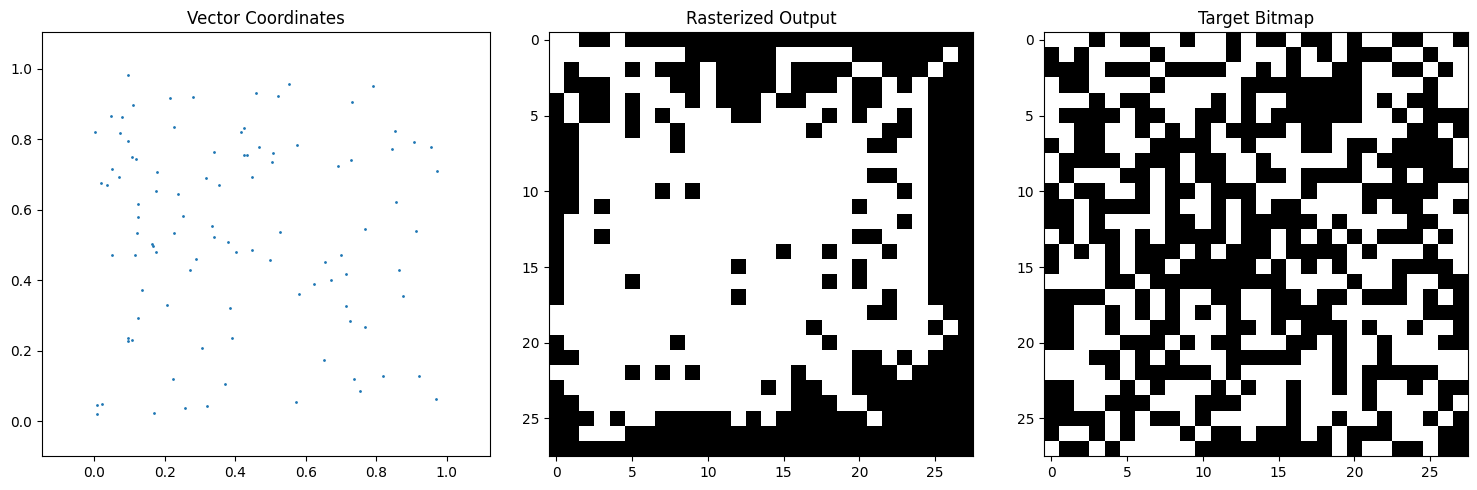

In [14]:
#losses.py
import jax
import jax.numpy as jnp
from jax import lax
import flax.linen as nn
from typing import Tuple, Dict, Optional
from functools import partial

class NimbleLoss(nn.Module):
    """Loss module for sketch generation"""
    coord_weight: float = 1.0
    raster_weight: float = 0.5
    canvas_size: Tuple[int, int] = (28, 28)  # Bitmap size
    
    def coordinate_loss(
        self,
        pred_coords: jnp.ndarray,
        target_coords: jnp.ndarray
    ) -> jnp.ndarray:
        """Compute L2 loss between predicted and target coordinates"""
        return jnp.mean((pred_coords - target_coords) ** 2)

    def _rasterize_line(
        self,
        x0: jnp.ndarray,
        y0: jnp.ndarray,
        x1: jnp.ndarray,
        y1: jnp.ndarray,
        canvas: jnp.ndarray
    ) -> jnp.ndarray:
        """Rasterize a single line using JAX control flow"""
        dx = jnp.abs(x1 - x0)
        dy = jnp.abs(y1 - y0)
        
        def swap_points(x0, y0, x1, y1):
            return y0, x0, y1, x1

        # Handle steep lines
        steep = dy > dx
        x0, y0, x1, y1 = lax.cond(
            steep,
            lambda args: swap_points(*args),
            lambda args: args,
            (x0, y0, x1, y1)
        )
        
        # Ensure x0 <= x1
        swap = x0 > x1
        x0, x1 = lax.cond(
            swap,
            lambda x: (x[1], x[0]),
            lambda x: x,
            (x0, x1)
        )
        y0, y1 = lax.cond(
            swap,
            lambda y: (y[1], y[0]),
            lambda y: y,
            (y0, y1)
        )
        
        dx = x1 - x0
        dy = jnp.abs(y1 - y0)
        ystep = jnp.where(y0 < y1, 1, -1)
        
        def plot_point(args):
            x, y, canvas = args
            # Handle steep vs non-steep lines
            plot_x = lax.cond(steep, lambda: y, lambda: x)
            plot_y = lax.cond(steep, lambda: x, lambda: y)
            
            # Check bounds
            valid = (plot_x >= 0) & (plot_x < canvas.shape[1]) & \
                   (plot_y >= 0) & (plot_y < canvas.shape[0])
            
            # Update canvas
            return lax.cond(
                valid,
                lambda: canvas.at[plot_y, plot_x].set(1.0),
                lambda: canvas
            )
        
        def body_fn(i, state):
            x = x0 + i
            y = y0 + (ystep * dy * i / dx).astype(jnp.int32)
            canvas = plot_point((x, y, state))
            return canvas
        
        # Draw the line using fori_loop
        canvas = lax.fori_loop( # a JAX equivalent of a Python for-loop, optimized for performance and compilation with jit.
            0,
            dx.astype(jnp.int32) + 1,
            body_fn,
            canvas
        )
        
        return canvas

    @partial(jax.jit, static_argnums=(0,))
    def rasterize_strokes(
        self,
        coords: jnp.ndarray
    ) -> jnp.ndarray:
        """Rasterize vector coordinates to image"""
        batch_size, num_points, _ = coords.shape
        H, W = self.canvas_size
        
        # Scale coordinates to pixel space
        coords = coords * jnp.array([W - 1, H - 1])
        coords = coords.astype(jnp.int32)
        
        def rasterize_single(coords_single):
            # Initialize empty canvas
            canvas = jnp.zeros(self.canvas_size)
            
            def draw_segment(i, canvas):
                x0, y0 = coords_single[i]
                x1, y1 = coords_single[i + 1]
                return self._rasterize_line(x0, y0, x1, y1, canvas)
            
            return lax.fori_loop(0, num_points - 1, draw_segment, canvas)
        
        # Vectorize over batch
        return jax.vmap(rasterize_single)(coords)
    
    def rasterization_loss(
        self,
        pred_coords: jnp.ndarray,
        target_coords: jnp.ndarray,
        target_bitmap: Optional[jnp.ndarray] = None
    ) -> jnp.ndarray:
        """Compute rasterization loss"""
        pred_raster = self.rasterize_strokes(pred_coords)
        
        if target_bitmap is not None:
            # Binary cross entropy with target bitmap
            epsilon = 1e-7
            pred_raster = jnp.clip(pred_raster, epsilon, 1.0 - epsilon)
            bce = -(target_bitmap * jnp.log(pred_raster) + 
                   (1 - target_bitmap) * jnp.log(1 - pred_raster))
            return jnp.mean(bce)
        else:
            # Compare with rasterized target coordinates
            target_raster = self.rasterize_strokes(target_coords)
            pred_raster = jnp.clip(pred_raster, 1e-7, 1.0 - 1e-7)
            bce = -(target_raster * jnp.log(pred_raster) + 
                   (1 - target_raster) * jnp.log(1 - pred_raster))
            return jnp.mean(bce)
    
    @partial(jax.jit, static_argnums=(0,))
    def __call__(
        self,
        pred_coords: jnp.ndarray,
        target_coords: jnp.ndarray,
        target_bitmap: Optional[jnp.ndarray] = None
    ) -> Dict[str, jnp.ndarray]:
        """Compute combined loss"""
        coord_loss = self.coordinate_loss(pred_coords, target_coords)
        raster_loss = self.rasterization_loss(pred_coords, target_coords, target_bitmap)
        
        total_loss = self.coord_weight * coord_loss + self.raster_weight * raster_loss
        
        return {
            'coord_loss': coord_loss,
            'raster_loss': raster_loss,
            'total_loss': total_loss
        }

def test_losses():
    """Test the loss implementation"""
    import jax.random as random
    import matplotlib.pyplot as plt
    
    # Create random key
    key = random.PRNGKey(0)
    
    # Create dummy data
    batch_size = 4
    num_points = 100
    H, W = 28, 28
    
    # Generate random coordinates
    key, subkey1, subkey2 = random.split(key, 3)
    pred_coords = random.uniform(subkey1, (batch_size, num_points, 2))
    target_coords = random.uniform(subkey2, (batch_size, num_points, 2))
    
    # Create random target bitmap
    key, subkey = random.split(key)
    target_bitmap = random.bernoulli(subkey, shape=(batch_size, H, W)).astype(jnp.float32)
    
    # Initialize loss
    criterion = NimbleLoss()
    
    # Test without target bitmap
    losses = criterion(pred_coords, target_coords)
    print("\nLosses without target bitmap:")
    for k, v in losses.items():
        print(f"{k}: {v}")
        
    # Test with target bitmap
    losses = criterion(pred_coords, target_coords, target_bitmap)
    print("\nLosses with target bitmap:")
    for k, v in losses.items():
        print(f"{k}: {v}")
    
    # Visualize rasterization
    rasterized = criterion.rasterize_strokes(pred_coords)
    
    # Plot first example
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.scatter(pred_coords[0, :, 0], pred_coords[0, :, 1], s=1)
    plt.title("Vector Coordinates")
    plt.axis('equal')
    
    plt.subplot(132)
    plt.imshow(rasterized[0], cmap='gray')
    plt.title("Rasterized Output")
    
    plt.subplot(133)
    plt.imshow(target_bitmap[0], cmap='gray')
    plt.title("Target Bitmap")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    test_losses()

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
from flax.training import train_state
from flax.training import checkpoints
import optax
import tensorflow as tf
from pathlib import Path
from typing import Tuple, Dict, Optional, Any
from tqdm import tqdm
import logging
from functools import partial
from jax.tree_util import tree_map

from dataset import get_dataloaders
from encoder import BitmapEncoder
from decoder import TransformerDecoder
from diffusion import DiffusionProcess
from losses import NimbleLoss

def get_device_name():
    """Get the best available device"""
    if jax.default_backend() == "gpu":
        return "cuda"
    elif jax.default_backend() == "cpu":
        # Check for MPS (Apple Silicon)
        try:
            if tf.config.list_physical_devices("GPU"):
                return "mps"
        except:
            pass
    return "cpu"


class TrainState(train_state.TrainState):
    batch_stats: Dict[str, Any]


def create_train_state(
    rng: jnp.ndarray,
    learning_rate: float,
    batch_size: int = 1,
    optimizer: Optional[optax.GradientTransformation] = None,
) -> TrainState:
    """Initialize training state with optimized configuration"""
    # Split PRNG key
    rng, encoder_key, decoder_key = random.split(rng, 3)

    # Initialize models
    encoder = BitmapEncoder(embed_dim=256)
    decoder = TransformerDecoder(d_model=256)

    # Initialize parameters with optimized settings
    encoder_variables = encoder.init(
        {"params": encoder_key, "batch_stats": encoder_key},
        jnp.ones((batch_size, 28, 28)),
        training=True,
    )

    decoder_variables = decoder.init(
        {"params": decoder_key},
        jnp.ones((batch_size, 100, 2)),
        jnp.zeros((batch_size,), dtype=jnp.int32),
        jnp.ones((batch_size, 256)),
        deterministic=False,
    )

    # Combine parameters and batch stats
    params = {
        "encoder": encoder_variables["params"],
        "decoder": decoder_variables["params"],
    }
    batch_stats = {"encoder": encoder_variables.get("batch_stats", {})}

    # Use provided optimizer or create default
    if optimizer is None:
        optimizer = optax.adam(learning_rate)

    return TrainState.create(
        apply_fn=None, params=params, tx=optimizer, batch_stats=batch_stats
    )


class NimbleTrainer:
    def __init__(
        self,
        learning_rate: float = 1e-5,  # Further reduced learning rate
        checkpoint_dir: str = "checkpoints",
        use_wandb: bool = False,
        batch_size: int = 32,
    ):
        """Initialize trainer with further optimized configurations"""
        # Previous initialization code remains the same
        self.device = get_device_name()
        print(f"Using device: {self.device}")

        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True)
        self.use_wandb = use_wandb

        # Initialize models
        self.encoder = BitmapEncoder(embed_dim=256)
        self.decoder = TransformerDecoder(d_model=256)
        self.diffusion = DiffusionProcess()
        self.criterion = NimbleLoss(
            coord_weight=0.5,  # Reduced coordinate weight
            raster_weight=0.05,  # Further reduced raster weight
        )

        # Initialize PRNG key
        self.rng = random.PRNGKey(0)

        # Create training state with optimized schedule
        schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=learning_rate,
            warmup_steps=200,  # Increased warmup steps
            decay_steps=15000,  # Increased decay steps
            end_value=learning_rate / 20.0,  # More aggressive decay
        )

        # Enhanced optimizer chain
        optimizer = optax.chain(
            optax.clip_by_global_norm(0.5),  # More aggressive gradient clipping
            optax.scale_by_adam(b1=0.9, b2=0.99),  # Adjusted beta parameters
            optax.scale_by_schedule(schedule),
        )

        self.state = create_train_state(
            self.rng, learning_rate, batch_size, optimizer=optimizer
        )

        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

        # Enhanced loss normalization
        self.coord_scale = 2000.0  # Increased coordinate scaling
        self.raster_scale = 0.5  # Reduced raster scaling

    def _forward(
        self,
        params: Dict,
        batch_stats: Dict,
        bitmap: jnp.ndarray,
        coords: jnp.ndarray,
        timesteps: jnp.ndarray,
        training: bool = True,
        rngs: Optional[Dict[str, jnp.ndarray]] = None,
    ) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        """Forward pass through the models"""
        # Get variables
        encoder_variables = {
            "params": params["encoder"],
            "batch_stats": batch_stats["encoder"],
        }
        decoder_variables = {"params": params["decoder"]}

        # Default RNGs if none provided
        if rngs is None:
            rngs = {}

        # Run encoder
        encoder_output = self.encoder.apply(
            encoder_variables,
            bitmap,
            training=training,
            mutable=["batch_stats"] if training else False,
            rngs=rngs,
        )
        if training:
            image_embeddings, new_encoder_stats = encoder_output
            new_batch_stats = {"encoder": new_encoder_stats["batch_stats"]}
        else:
            image_embeddings = encoder_output
            new_batch_stats = {}

        # Run decoder
        pred_coords = self.decoder.apply(
            decoder_variables,
            coords,
            timesteps,
            image_embeddings,
            deterministic=not training,
            rngs=rngs,
        )

        return pred_coords, new_batch_stats

    @partial(jax.jit, static_argnames=("self", "training"))
    def _forward_jit(
        self,
        params: Dict,
        batch_stats: Dict,
        bitmap: jnp.ndarray,
        coords: jnp.ndarray,
        timesteps: jnp.ndarray,
        training: bool = True,
        rngs: Optional[Dict[str, jnp.ndarray]] = None,
    ) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        return self._forward(
            params, batch_stats, bitmap, coords, timesteps, training, rngs
        )

    def compute_loss(
        self,
        pred_coords: jnp.ndarray,
        target_coords: jnp.ndarray,
        target_bitmap: jnp.ndarray,
    ) -> Dict[str, jnp.ndarray]:
        """Compute losses with enhanced normalization"""
        # Apply pre-normalization to coordinates
        pred_coords = pred_coords / self.coord_scale
        target_coords = target_coords / self.coord_scale

        losses = self.criterion(pred_coords, target_coords, target_bitmap)

        # Post-process losses
        losses = {
            "coord_loss": losses["coord_loss"] * self.coord_scale,
            "raster_loss": losses["raster_loss"] * self.raster_scale,
            "total_loss": (
                losses["coord_loss"] * self.coord_scale * self.criterion.coord_weight
                + losses["raster_loss"]
                * self.raster_scale
                * self.criterion.raster_weight
            ),
        }

        return losses

    @partial(jax.jit, static_argnames=("self",))
    def compute_loss_jit(
        self,
        pred_coords: jnp.ndarray,
        target_coords: jnp.ndarray,
        target_bitmap: jnp.ndarray,
    ) -> Dict[str, jnp.ndarray]:
        return self.compute_loss(pred_coords, target_coords, target_bitmap)

    def _train_step_impl(
        self,
        state: TrainState,
        bitmap: jnp.ndarray,
        coords: jnp.ndarray,
        timesteps: jnp.ndarray,
        noise_key: jnp.ndarray,
        dropout_key: jnp.ndarray,
    ) -> Tuple[TrainState, Dict[str, jnp.ndarray]]:
        """Implementation of single training step"""
        # Add noise to target coordinates
        noised_coords, noise = self.diffusion.add_noise(noise_key, coords, timesteps)

        # Prepare RNG dict for dropout
        rngs = {"dropout": dropout_key}

        # Forward pass and loss computation
        pred_coords, new_batch_stats = self._forward_jit(
            state.params,
            state.batch_stats,
            bitmap,
            noised_coords,
            timesteps,
            True,  # training
            rngs=rngs,
        )

        losses = self.compute_loss_jit(pred_coords, coords, bitmap)

        # Compute gradients
        grad_fn = jax.value_and_grad(lambda p: losses["total_loss"])
        _, grads = grad_fn(state.params)

        # Update parameters and batch stats
        state = state.apply_gradients(grads=grads, batch_stats=new_batch_stats)

        return state, losses

    @partial(jax.jit, static_argnames=("self",))
    def train_step_jit(
        self,
        state: TrainState,
        bitmap: jnp.ndarray,
        coords: jnp.ndarray,
        timesteps: jnp.ndarray,
        noise_key: jnp.ndarray,
        dropout_key: jnp.ndarray,
    ) -> Tuple[TrainState, Dict[str, jnp.ndarray]]:
        return self._train_step_impl(
            state, bitmap, coords, timesteps, noise_key, dropout_key
        )

    def train_step(
        self,
        state: TrainState,
        batch: Tuple[jnp.ndarray, jnp.ndarray],
        rng: jnp.ndarray,
    ) -> Tuple[TrainState, Dict[str, jnp.ndarray]]:
        """Single training step with proper handling of dynamic shapes"""
        bitmap, coords = batch

        # Split PRNG keys for different random operations
        rng, timestep_key, noise_key, dropout_key = random.split(rng, 4)

        # Sample timesteps
        timesteps = self.diffusion.sample_timesteps(timestep_key, bitmap.shape[0])

        return self.train_step_jit(
            state, bitmap, coords, timesteps, noise_key, dropout_key
        )

    def eval_step(
        self,
        state: TrainState,
        batch: Tuple[jnp.ndarray, jnp.ndarray],
        rng: jnp.ndarray,
    ) -> Dict[str, jnp.ndarray]:
        """Single evaluation step"""
        bitmap, target_coords = batch

        # Split PRNG keys
        rng, timestep_key, noise_key = random.split(rng, 3)

        # Sample timesteps
        timesteps = self.diffusion.sample_timesteps(timestep_key, bitmap.shape[0])

        # Add noise to target coordinates
        noised_coords, noise = self.diffusion.add_noise(
            noise_key, target_coords, timesteps
        )

        # Forward pass (no dropout in eval)
        pred_coords, _ = self._forward_jit(
            state.params,
            state.batch_stats,
            bitmap,
            noised_coords,
            timesteps,
            False,  # not training
        )

        # Compute losses
        return self.compute_loss_jit(pred_coords, target_coords, bitmap)

    @partial(jax.jit, static_argnames=("self",))
    def eval_step_jit(self, *args, **kwargs):
        return self.eval_step(*args, **kwargs)

    def train(
        self,
        train_dataset: tf.data.Dataset,
        val_dataset: Optional[tf.data.Dataset] = None,
        num_epochs: int = 100,
        validate_every: int = 1,
    ):
        """Train the model"""
        best_val_loss = float("inf")

        for epoch in range(num_epochs):
            self.logger.info(f"Epoch {epoch + 1}/{num_epochs}")

            # Training
            train_losses = []
            pbar = tqdm(train_dataset, desc="Training")
            for batch in pbar:
                # Convert TF tensors to JAX arrays
                bitmap = jnp.array(batch[0].numpy())
                coords = jnp.array(batch[1].numpy())

                # Split PRNG key
                self.rng, step_key = random.split(self.rng)

                # Training step
                self.state, losses = self.train_step(
                    self.state, (bitmap, coords), step_key
                )
                train_losses.append(losses)

                # Update progress bar
                pbar.set_postfix(
                    {
                        "loss": float(losses["total_loss"]),
                        "coord_loss": float(losses["coord_loss"]),
                        "raster_loss": float(losses["raster_loss"]),
                    }
                )

            # Calculate average training losses using updated JAX function
            from jax.tree_util import tree_map

            train_metrics = tree_map(lambda *x: jnp.mean(jnp.stack(x)), *train_losses)

            # Save regular checkpoint every 10 epochs
            if (epoch + 1) % 10 == 0:
                self.save_checkpoint(
                    epoch,
                    train_metrics,
                    is_best=False,
                    checkpoint_name=f"checkpoint_epoch_{epoch}",
                )

            # Validation
            if val_dataset is not None and epoch % validate_every == 0:
                val_losses = []
                for batch in tqdm(val_dataset, desc="Validation"):
                    bitmap = jnp.array(batch[0].numpy())
                    coords = jnp.array(batch[1].numpy())

                    self.rng, step_key = random.split(self.rng)
                    losses = self.eval_step(self.state, (bitmap, coords), step_key)
                    val_losses.append(losses)

                # Calculate average validation losses
                val_metrics = tree_map(lambda *x: jnp.mean(jnp.stack(x)), *val_losses)

                # Log metrics
                self.logger.info(
                    f"Train Loss: {float(train_metrics['total_loss']):.4f}, "
                    f"Val Loss: {float(val_metrics['total_loss']):.4f}"
                )

                if self.use_wandb:
                    metrics = {
                        **{f"train_{k}": float(v) for k, v in train_metrics.items()},
                        **{f"val_{k}": float(v) for k, v in val_metrics.items()},
                    }
                    wandb.log(metrics, step=epoch)

                # Check and save best model
                current_val_loss = float(val_metrics["total_loss"])
                if current_val_loss < best_val_loss:
                    best_val_loss = current_val_loss
                    self.logger.info(f"New best validation loss: {best_val_loss:.4f}")
                    # Save best model in a separate directory
                    best_checkpoint_path = f"best_model_epoch_{epoch}"
                    self.save_checkpoint(
                        epoch,
                        val_metrics,
                        is_best=True,
                        checkpoint_name=best_checkpoint_path,
                    )

    def save_checkpoint(
        self,
        epoch: int,
        metrics: Dict[str, jnp.ndarray],
        is_best: bool = False,
        checkpoint_name: str = None,
    ):
        """Save model checkpoint"""
        checkpoint = {
            "epoch": epoch,
            "state": self.state,
            "metrics": metrics,
            "best_val_loss": getattr(self, "best_val_loss", None),
        }

        if checkpoint_name is None:
            checkpoint_name = f"checkpoint_epoch_{epoch}"

        # Convert to absolute path
        checkpoint_path = self.checkpoint_dir.absolute() / checkpoint_name

        # Set keep parameter based on checkpoint type
        if is_best:
            keep = 1  # Only keep the best checkpoint
        else:
            keep = 2  # Keep last 2 regular checkpoints

        checkpoints.save_checkpoint(
            str(checkpoint_path),  # Convert Path to string
            checkpoint,
            epoch,
            keep=keep,  # Always specify a number for keep
        )

        self.logger.info(
            f"Saved {'best ' if is_best else ''}checkpoint to {checkpoint_path}"
        )

    def load_checkpoint(self, checkpoint_path: str):
        """Load model checkpoint"""
        # Convert to absolute path if necessary
        checkpoint_path = Path(checkpoint_path).absolute()
        checkpoint = checkpoints.restore_checkpoint(str(checkpoint_path), target=None)
        self.state = checkpoint["state"]
        if "best_val_loss" in checkpoint:
            self.best_val_loss = checkpoint["best_val_loss"]
        return checkpoint["epoch"], checkpoint["metrics"]


def main():
    """Main training function with improved configurations"""
    # Get datasets
    train_ds, val_ds = get_dataloaders(
        data_path="../data/full-simplified-bird.ndjson", batch_size=32, num_points=100
    )

    # Create trainer with improved hyperparameters
    trainer = NimbleTrainer(
        learning_rate=3e-5, use_wandb=False, batch_size=32  # Lower learning rate
    )

    # Start training
    trainer.train(
        train_ds,
        val_ds,
        num_epochs=1,
        # num_epochs=100, // Lol i cant wait. If you have gpu you can.
        validate_every=1,
    )


if __name__ == "__main__":
    main()

Using device: mps


Validation: 100%|██████████| 698/698 [03:53<00:00,  2.98it/s]


Initializing inference model...
Using device: cpu


/Users/jeff/.pyenv/versions/3.11.4/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Checkpoint keys: dict_keys(['best_val_loss', 'epoch', 'metrics', 'state'])
State keys: dict_keys(['batch_stats', 'opt_state', 'params', 'step'])
Encoder params keys: ['ConvBNAct_0', 'ConvBNAct_1', 'ConvBNAct_2', 'Conv_0', 'InvertedResidual_0', 'InvertedResidual_1']
Decoder params keys: ['coord_embed', 'layers_0', 'layers_1', 'layers_2', 'layers_3', 'layers_4', 'layers_5', 'output_proj', 'timestep_embed']
Batch stats keys: ['ConvBNAct_0', 'ConvBNAct_1', 'ConvBNAct_2', 'InvertedResidual_0', 'InvertedResidual_1']
Successfully loaded checkpoint from /Users/jeff/Documents/cactus-brain/ai/projects/research/nimble/deploy-jax/checkpoints/best_model/checkpoint_0

Test with image file...


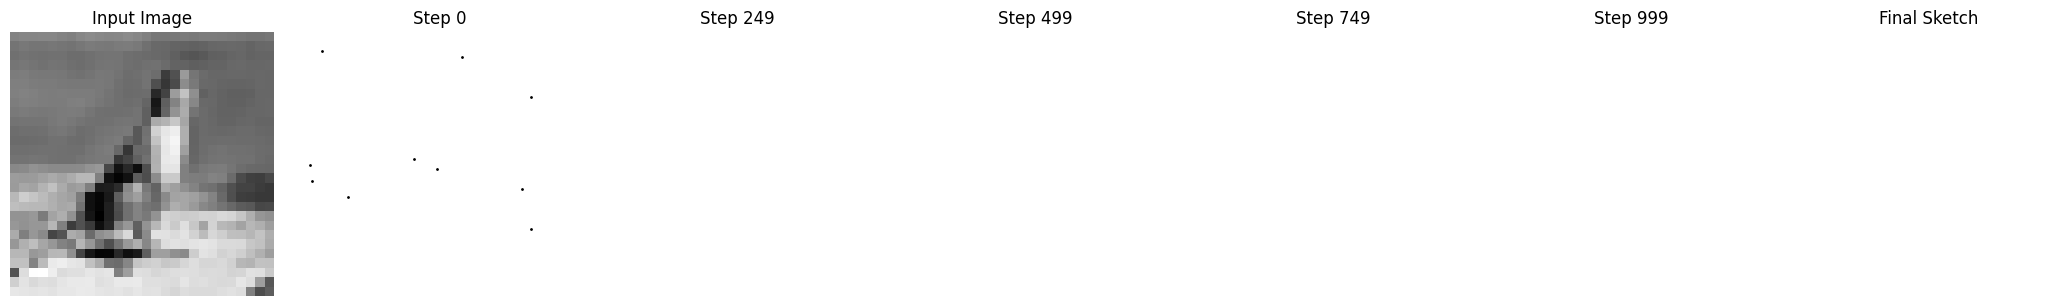

✓ Test with image file completed successfully

Test with numpy array...


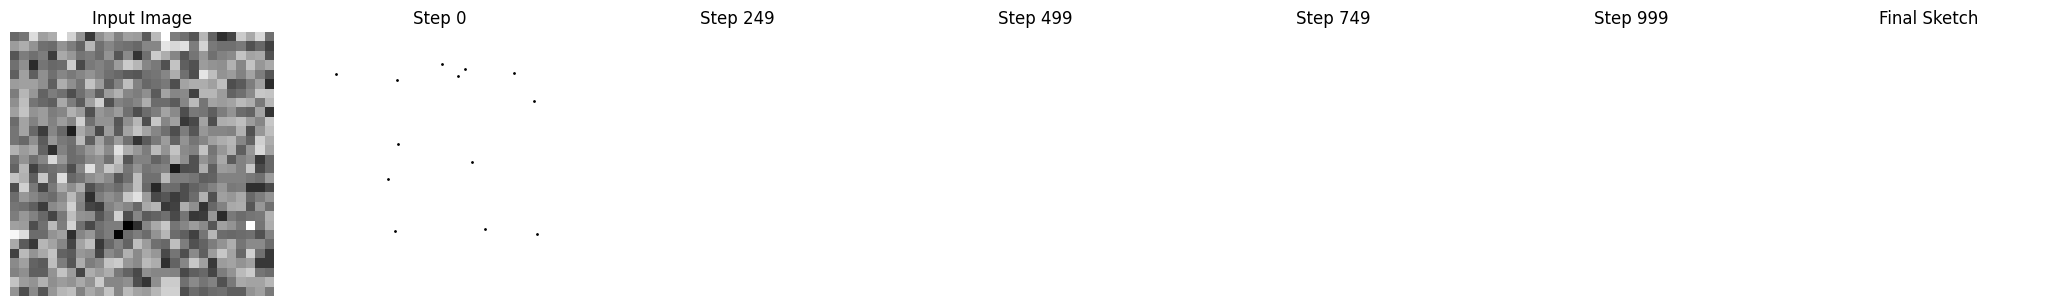

✓ Test with numpy array completed successfully

Test with PIL Image...


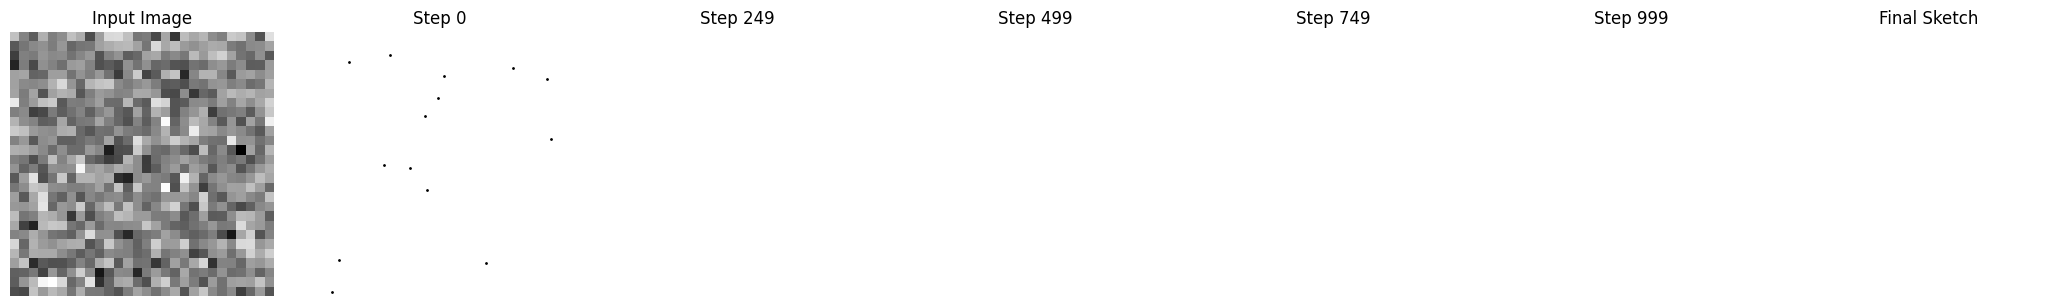

✓ Test with PIL Image completed successfully

All tests completed.


In [32]:
# inference.py

import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
from flax.training import checkpoints
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import Optional, Union, Tuple, List
from pathlib import Path
from functools import partial

from encoder import BitmapEncoder
from decoder import TransformerDecoder
from diffusion import DiffusionProcess

class NimbleInference:
    def __init__(
        self,
        checkpoint_path: str,
        image_size: Tuple[int, int] = (28, 28),
        num_points: int = 100
    ):
        """Initialize inference model"""
        self.image_size = image_size
        self.num_points = num_points
        self.rng = random.PRNGKey(0)
        
        self.device = self._get_device()
        print(f"Using device: {self.device}")
        
        try:
            self.encoder = BitmapEncoder(embed_dim=256)
            self.decoder = TransformerDecoder(d_model=256)
            self.diffusion = DiffusionProcess()
            
            self._forward_encoder_impl = jax.jit(self._forward_encoder_impl)
            self._forward_decoder_impl = jax.jit(self._forward_decoder_impl)
            
        except Exception as e:
            raise RuntimeError(f"Failed to initialize models: {str(e)}")
        
        self._load_checkpoint_with_verification(checkpoint_path)

    def _process_input(
        self, 
        input_data: Union[str, Image.Image, jnp.ndarray, np.ndarray]
    ) -> jnp.ndarray:
        """Process input into bitmap array"""
        if isinstance(input_data, str):
            input_data = Image.open(input_data).convert('L')
        
        if isinstance(input_data, Image.Image):
            input_data = input_data.resize(self.image_size)
            input_data = np.array(input_data)
        
        if isinstance(input_data, np.ndarray):
            if input_data.ndim == 3:
                input_data = np.mean(input_data, axis=2)
            if input_data.shape != self.image_size:
                temp_img = Image.fromarray((input_data * 255).astype('uint8'))
                temp_img = temp_img.resize(self.image_size)
                input_data = np.array(temp_img)
        
        bitmap = jnp.array(input_data, dtype=jnp.float32) / 255.0
        if bitmap.ndim == 2:
            bitmap = bitmap[None, ..., None]
        elif bitmap.ndim == 3 and bitmap.shape[-1] > 1:
            bitmap = jnp.mean(bitmap, axis=-1)[None, ..., None]
        
        return bitmap

    def _forward_encoder_impl(
        self,
        encoder_params: dict,
        batch_stats: dict,
        bitmap: jnp.ndarray
    ) -> jnp.ndarray:
        """Implementation of encoder forward pass"""
        encoder_variables = {
            'params': encoder_params,
            'batch_stats': batch_stats
        }
        return self.encoder.apply(
            encoder_variables,
            bitmap,
            training=False,
            mutable=False
        )

    def _forward_decoder_impl(
        self,
        decoder_params: dict,
        coords: jnp.ndarray,
        t: jnp.ndarray,
        image_embedding: jnp.ndarray
    ) -> jnp.ndarray:
        """Implementation of decoder forward pass"""
        decoder_variables = {'params': decoder_params}
        return self.decoder.apply(
            decoder_variables,
            coords,
            t,
            image_embedding,
            deterministic=True
        )

    def _forward_encoder(
        self,
        bitmap: jnp.ndarray
    ) -> jnp.ndarray:
        """Forward pass through encoder using stored parameters"""
        return self._forward_encoder_impl(
            self.encoder_params,
            self.batch_stats,
            bitmap
        )

    def _forward_decoder(
        self,
        coords: jnp.ndarray,
        t: jnp.ndarray,
        image_embedding: jnp.ndarray
    ) -> jnp.ndarray:
        """Forward pass through decoder using stored parameters"""
        return self._forward_decoder_impl(
            self.decoder_params,
            coords,
            t,
            image_embedding
        )

    def _get_device(self) -> str:
        """Get the best available device with error handling"""
        try:
            if jax.default_backend() == "gpu":
                return "cuda"
            elif jax.default_backend() == "cpu":
                try:
                    if any(dev.device_type == "gpu" for dev in jax.local_devices()):
                        return "mps"
                except:
                    pass
            return "cpu"
        except Exception as e:
            print(f"Warning: Error detecting device, defaulting to CPU. Error: {str(e)}")
            return "cpu"
    
    def _load_checkpoint_with_verification(self, checkpoint_path: str):
        """Load and verify checkpoint with proper parameter restructuring"""
        try:
            checkpoint_path = Path(checkpoint_path).absolute()
            if not checkpoint_path.exists():
                checkpoint_with_suffix = checkpoint_path.parent / "checkpoint_0"
                if checkpoint_with_suffix.exists():
                    checkpoint_path = checkpoint_with_suffix
                else:
                    raise FileNotFoundError(
                        f"Checkpoint path does not exist: {checkpoint_path}\n"
                        f"Attempted alternate path: {checkpoint_with_suffix}"
                    )
            
            checkpoint = checkpoints.restore_checkpoint(str(checkpoint_path), target=None)
            if checkpoint is None:
                raise ValueError(f"Failed to load checkpoint from {checkpoint_path}")
            
            print("Checkpoint keys:", checkpoint.keys())
            
            if 'state' not in checkpoint:
                raise ValueError("Checkpoint missing 'state' key")
            
            state = checkpoint['state']
            print("State keys:", state.keys())
            
            if 'params' not in state or 'batch_stats' not in state:
                raise ValueError("State missing required keys: params and/or batch_stats")
            
            # Extract encoder and decoder parameters separately
            self.encoder_params = state['params']['encoder']
            self.decoder_params = state['params']['decoder']
            self.batch_stats = state['batch_stats']['encoder']
            
            # Debug print to verify parameter structure
            print("Encoder params keys:", list(self.encoder_params.keys()))
            print("Decoder params keys:", list(self.decoder_params.keys()))
            print("Batch stats keys:", list(self.batch_stats.keys()))
            
            print(f"Successfully loaded checkpoint from {checkpoint_path}")
            
        except Exception as e:
            error_msg = (
                f"Error loading checkpoint: {str(e)}\n\n"
                "Potential solutions:\n"
                "1. Ensure you have run the training process first\n"
                "2. Check the checkpoint path is correct\n"
                "3. Verify the checkpoint file isn't corrupted\n"
                "4. Make sure you're using the same model version that created the checkpoint"
            )
            raise RuntimeError(error_msg) from e

    def generate(
        self,
        input_data: Union[str, Image.Image, jnp.ndarray, np.ndarray],
        temperature: float = 1.0,
        return_process: bool = False
    ) -> Union[jnp.ndarray, Tuple[jnp.ndarray, List[jnp.ndarray]]]:
        """Generate sketch coordinates from input image"""
        bitmap = self._process_input(input_data)
        image_embedding = self._forward_encoder(bitmap)
        
        self.rng, init_key = random.split(self.rng)
        coords = random.normal(
            init_key,
            shape=(1, self.num_points, 2)
        ) * temperature
        
        process = [] if return_process else None
        
        timesteps = jnp.arange(self.diffusion.num_timesteps - 1, -1, -1)
        
        for t in timesteps:
            if process is not None:
                process.append(coords)
            
            t_batch = jnp.array([t])
            pred_coords = self._forward_decoder(coords, t_batch, image_embedding)
            
            if t > 0:
                coords = self.diffusion.remove_noise(coords, pred_coords, t_batch)
                self.rng, noise_key = random.split(self.rng)
                noise = random.normal(noise_key, coords.shape) * temperature
                coords = coords + noise * (t / self.diffusion.num_timesteps)
        
        if return_process:
            return coords, process
        return coords

    def visualize_generation(
        self,
        input_data: Union[str, Image.Image, jnp.ndarray, np.ndarray],
        temperature: float = 1.0,
        num_steps: int = 5
    ):
        """Visualize the generation process"""
        coords, process = self.generate(input_data, temperature, return_process=True)
        bitmap = self._process_input(input_data)
        bitmap_display = np.array(bitmap[0, ..., 0])
        
        step_indices = np.linspace(0, len(process) - 1, num_steps, dtype=int)
        
        fig, axes = plt.subplots(1, num_steps + 2, figsize=(3 * (num_steps + 2), 3))
        
        axes[0].imshow(bitmap_display, cmap='gray')
        axes[0].set_title("Input Image")
        axes[0].axis("off")
        
        for i, idx in enumerate(step_indices):
            step_coords = np.array(process[idx][0])
            axes[i + 1].scatter(step_coords[:, 0], step_coords[:, 1], s=1, c="black")
            axes[i + 1].set_xlim(0, 1)
            axes[i + 1].set_ylim(0, 1)
            axes[i + 1].invert_yaxis()
            axes[i + 1].set_aspect("equal")
            axes[i + 1].axis("off")
            axes[i + 1].set_title(f"Step {idx}")
        
        final_coords = np.array(coords[0])
        axes[-1].scatter(final_coords[:, 0], final_coords[:, 1], s=1, c="black")
        axes[-1].set_xlim(0, 1)
        axes[-1].set_ylim(0, 1)
        axes[-1].invert_yaxis()
        axes[-1].set_aspect("equal")
        axes[-1].axis("off")
        axes[-1].set_title("Final Sketch")
        
        plt.tight_layout()
        plt.show()

def test_inference():
    """Test the inference and visualization with enhanced error handling"""
    try:
        print("Initializing inference model...")
        inferencer = NimbleInference(
            checkpoint_path="checkpoints/best_model/checkpoint",
            image_size=(28, 28),
            num_points=100
        )
        
        test_cases = [
            ("Test with image file", "../test_images/bird_0.jpg"),
            ("Test with numpy array", np.random.rand(100, 100, 3)),
            ("Test with PIL Image", Image.fromarray(
                (np.random.rand(100, 100, 3) * 255).astype('uint8')
            ))
        ]
        
        for test_name, test_input in test_cases:
            try:
                print(f"\n{test_name}...")
                inferencer.visualize_generation(test_input, temperature=0.8)
                print(f"✓ {test_name} completed successfully")
            except Exception as e:
                print(f"✗ {test_name} failed: {str(e)}")
        
        return True
        
    except Exception as e:
        print("\nTest failed with error:")
        print(f"{str(e)}")
        print("\nPlease ensure:")
        print("1. The model has been trained and checkpoints are saved")
        print("2. All required dependencies are installed")
        print("3. Test images are available in the correct location")
        return False

if __name__ == "__main__":
    success = test_inference();
    if success:
        print("\nAll tests completed.")
    else:
        print("\nTests failed. Please check the error messages above.")